In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential

# Load tensorboard extensions
%load_ext tensorboard
from tensorboard.plugins.hparams import api as hp

## Data

In [2]:
df = pd.read_csv('../data/energy_data_cleaned.csv')
df = df.drop(['timestamp', 'year_built'], axis=1)

## Preprocessing

In [3]:
# Split data
X = df.drop('target', axis=1)
Y = df['target']

# 85% training, 15% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

# Taking 15% of the training data for validation
num_validation_samples = int(0.15 * X_train.shape[0])
X_val = X_train.iloc[:num_validation_samples]
y_val = y_train.iloc[:num_validation_samples]

X_train = X_train.iloc[num_validation_samples:]
y_train = y_train.iloc[num_validation_samples:]

print('70% training:', X_train.shape)
print('15% validation: ', X_val.shape)
print('15% test: ', X_test.shape)


70% training: (757430, 21)
15% validation:  (133664, 21)
15% test:  (157252, 21)


In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [5]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


### Defining hyperparameters

In [6]:
HP_NUM_UNITS = hp.HParam('units', hp.Discrete([32, 64, 128]))
HP_REC_DROPOUT = hp.HParam('recurrent_dropout', hp.Discrete([0.0, 0.2]))
HP_MERGE_MODE = hp.HParam('merge_mode', hp.Discrete(['concat', 'sum', 'ave', 'mul']))

METRIC_MAE = 'MAE'
METRIC_MSE = 'MSE'
METRIC_RMSE = 'RMSE'
METRIC_R2 = 'R2'

with tf.summary.create_file_writer('logs/bidir_lstm_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_REC_DROPOUT, HP_MERGE_MODE],
        metrics=[hp.Metric(METRIC_MAE, display_name='MAE'),
                hp.Metric(METRIC_MSE, display_name='MSE'),
                hp.Metric(METRIC_RMSE, display_name='RMSE'),
                hp.Metric(METRIC_R2, display_name='R2')]
    )

In [7]:
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())
    return r2

In [8]:
def train_test_bidir_model(log_dir, hparams):
    # Define model with Bidirectional LSTM
    model = Sequential([
        Input(shape=(1, X_train_scaled.shape[2])),
        Bidirectional(LSTM(units=hparams[HP_NUM_UNITS], 
                           recurrent_dropout=hparams[HP_REC_DROPOUT]),
                     merge_mode=hparams[HP_MERGE_MODE]),
        Dense(units=1)
    ])
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=['mae', 'mse', r2_metric])
    
    # TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    
    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        X_train_scaled, 
        y_train_scaled, 
        epochs=50,  # Increased epochs with early stopping
        batch_size=256, 
        validation_data=(X_val_scaled, y_val_scaled),
        callbacks=[tensorboard_callback, early_stopping],
        verbose=1
    )

    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_orig = scaler.inverse_transform(y_test_scaled)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test_orig, y_pred)
    mse = mean_squared_error(y_test_orig, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_orig, y_pred)

    print(f'\nBidirectional LSTM with hyperparameters:')
    print(f'Num units: {hparams[HP_NUM_UNITS]}, Recurrent dropout: {hparams[HP_REC_DROPOUT]}, Merge mode: {hparams[HP_MERGE_MODE]}')
    print(f'Test performance metrics:')
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}\n")

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_orig, y_pred, alpha=0.5)
    plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Bidirectional LSTM: Actual vs Predicted (R² = {r2:.4f})')
    plt.savefig(f"{log_dir}/prediction_plot.png")
    plt.close()
    
    return mae, mse, rmse, r2
    

In [9]:
def run(log_dir, hparams):
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        mae, mse, rmse, r2 = train_test_bidir_model(log_dir, hparams)
        # register test performance metrics
        tf.summary.scalar(METRIC_MAE, mae, step=1)
        tf.summary.scalar(METRIC_MSE, mse, step=1)
        tf.summary.scalar(METRIC_RMSE, rmse, step=1)
        tf.summary.scalar(METRIC_R2, r2, step=1)

# Hyperparameter tuning
session_num = 0

for units in HP_NUM_UNITS.domain.values:
    for dropout in HP_REC_DROPOUT.domain.values:
        for merge_mode in HP_MERGE_MODE.domain.values:
            hparams = {
                HP_NUM_UNITS: units,
                HP_REC_DROPOUT: dropout,
                HP_MERGE_MODE: merge_mode
            }
            run_name = f"bidir_run-{session_num}"
            print(f'--- Starting trial: {run_name}')
            print({h.name: hparams[h] for h in hparams})
            
            run(f'logs/bidir_lstm_tuning/{run_name}', hparams)
            
            session_num += 1

# Visualize results with TensorBoard
%tensorboard --logdir "logs/bidir_lstm_tuning"


--- Starting trial: bidir_run-0
{'units': 32, 'recurrent_dropout': 0.0, 'merge_mode': 'ave'}
Epoch 1/50
2959/2959 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1653 - mae: 0.2662 - mse: 0.1653 - r2_metric: 0.8335 - val_loss: 0.0380 - val_mae: 0.1232 - val_mse: 0.0380 - val_r2_metric: 0.9616
Epoch 2/50
2959/2959 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0337 - mae: 0.1142 - mse: 0.0337 - r2_metric: 0.9660 - val_loss: 0.0278 - val_mae: 0.1035 - val_mse: 0.0278 - val_r2_metric: 0.9719
Epoch 3/50
2959/2959 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0262 - mae: 0.0987 - mse: 0.0262 - r2_metric: 0.9737 - val_loss: 0.0234 - val_mae: 0.0917 - val_mse: 0.0234 - val_r2_metric: 0.9763
Epoch 4/50
2959/2959 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0229 - mae: 0.0906 - mse: 0.0229 - r2_metric: 0.9769 - val_loss: 0.0212 - val_mae: 0.0854 - val_mse: 0.0212 - val_r2_metric: 0.9786
Epoch 5/50
2959/2959 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0213 - mae: 0.0857 - mse: 0.0213 - r2_metric: 0.9786 - val_

In [ ]:
def build_best_model(units=64, recurrent_dropout=0.2, merge_mode='concat'):
    model = Sequential([
        Input(shape=(1, X_train_scaled.shape[2])),
        Bidirectional(LSTM(units=units, 
                           recurrent_dropout=recurrent_dropout),
                     merge_mode=merge_mode),
        Dense(units=1)
    ])
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=['mae', 'mse', r2_metric])
    
    return model

best_model = build_best_model(units=64, recurrent_dropout=0.2, merge_mode='concat')

# Train the best model
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = best_model.fit(
    X_train_scaled, 
    y_train_scaled, 
    epochs=100,
    batch_size=256, 
    validation_data=(X_val_scaled, y_val_scaled),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
2959/2959 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.1359 - mae: 0.2356 - mse: 0.1359 - r2_metric: 0.8640 - val_loss: 0.0368 - val_mae: 0.1202 - val_mse: 0.0368 - val_r2_metric: 0.9629
Epoch 2/100
2959/2959 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0333 - mae: 0.1135 - mse: 0.0333 - r2_metric: 0.9665 - val_loss: 0.0293 - val_mae: 0.1073 - val_mse: 0.0293 - val_r2_metric: 0.9704
Epoch 3/100
2959/2959 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0271 - mae: 0.1007 - mse: 0.0271 - r2_metric: 0.9727 - val_loss: 0.0254 - val_mae: 0.0982 - val_mse: 0.0254 - val_r2_metric: 0.9744
Epoch 4/100
2959/2959 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0240 - mae: 0.0934 - mse: 0.0240 - r2_metric: 0.9759 - val_loss: 0.0224 - val_mae: 0.0896 - val_mse: 0.0224 - val_r2_metric: 0.9774
Epoch 5/100
2959/2959 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0223 - mae: 0.0886 - mse: 0.0223 - r2_metric: 0.9775 - val_loss: 0.0210 - val_mae: 0.0854 - val_mse: 0.0210 - val_r2_metric: 0.9788
Epoch 6/100
295

4915/4915 ━━━━━━━━━━━━━━━━━━━━ 2s 326us/step

Final Best Bidirectional LSTM Model Performance:
MAE: 0.1001
MSE: 0.0349
RMSE: 0.1869
R2: 0.9868


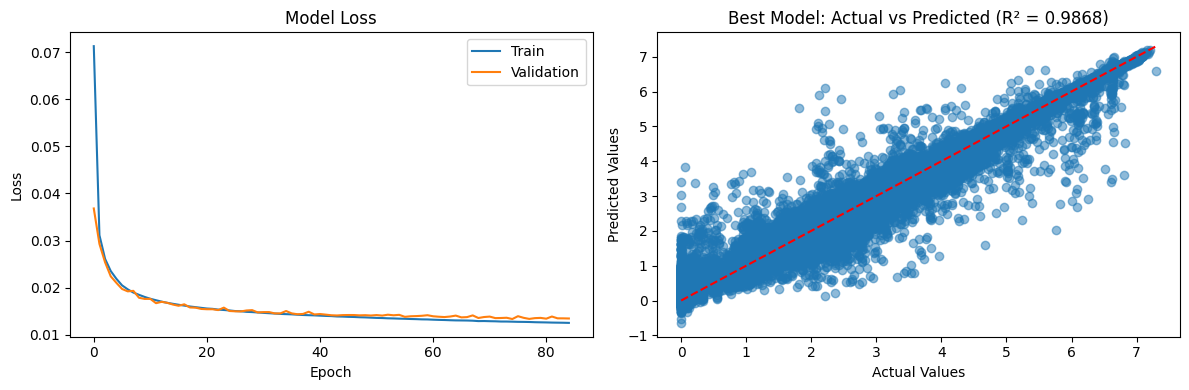

In [ ]:

# Evaluate the best model
y_pred_scaled = best_model.predict(X_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_orig = scaler.inverse_transform(y_test_scaled)

# Calculate and display final metrics
mae = mean_absolute_error(y_test_orig, y_pred)
mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, y_pred)

print("\nFinal Best Bidirectional LSTM Model Performance:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Plot training & validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot actual vs predicted values
plt.subplot(1, 2, 2)
plt.scatter(y_test_orig, y_pred, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Best Model: Actual vs Predicted (R² = {r2:.4f})')
plt.tight_layout()
plt.show()

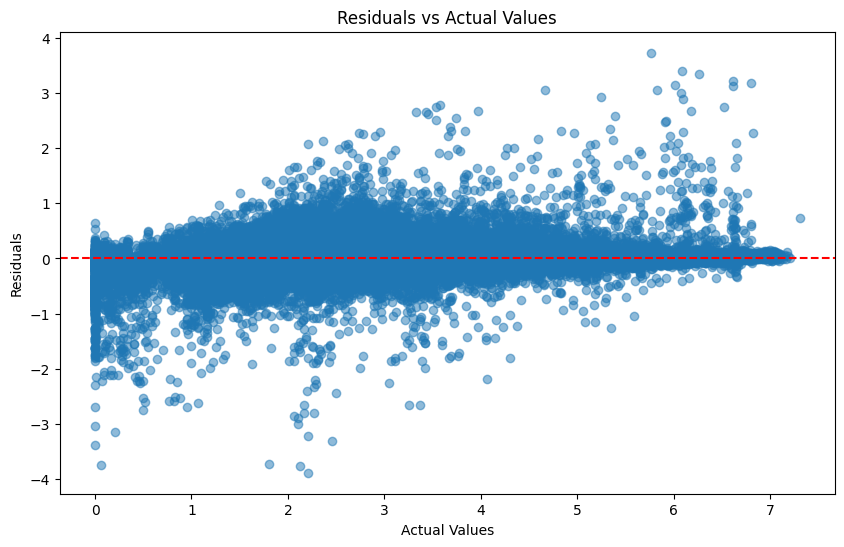

In [12]:
# plot residuals
plt.figure(figsize=(10, 6))
residuals = y_test_orig - y_pred
plt.scatter(y_test_orig, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Values')
plt.show()